<a href="https://colab.research.google.com/github/helen-oy/data-science-internship-hamoye/blob/main/Stage_D_NEURAL_NETWORK_hamoye_internship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing data and libraries

In [ ]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#parameters for preprocessing

In [ ]:
import gc 
from matplotlib import pyplot 
from matplotlib.image import imread
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras 
from tqdm import tqdm
from sklearn.model_selection import train_test_split 


In [ ]:
 #parameters for modelling 
from keras import optimizers
from keras.models import Sequential , Model
from keras.layers import Input , Dense , Dropout , Flatten
from keras.layers import Conv2D,MaxPooling2D , BatchNormalization
from keras.callbacks import EarlyStopping,ModelCheckpoint 
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [ ]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2
 
    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)
 
    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)
 
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
 
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
 
    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

Visualize images and read csv files

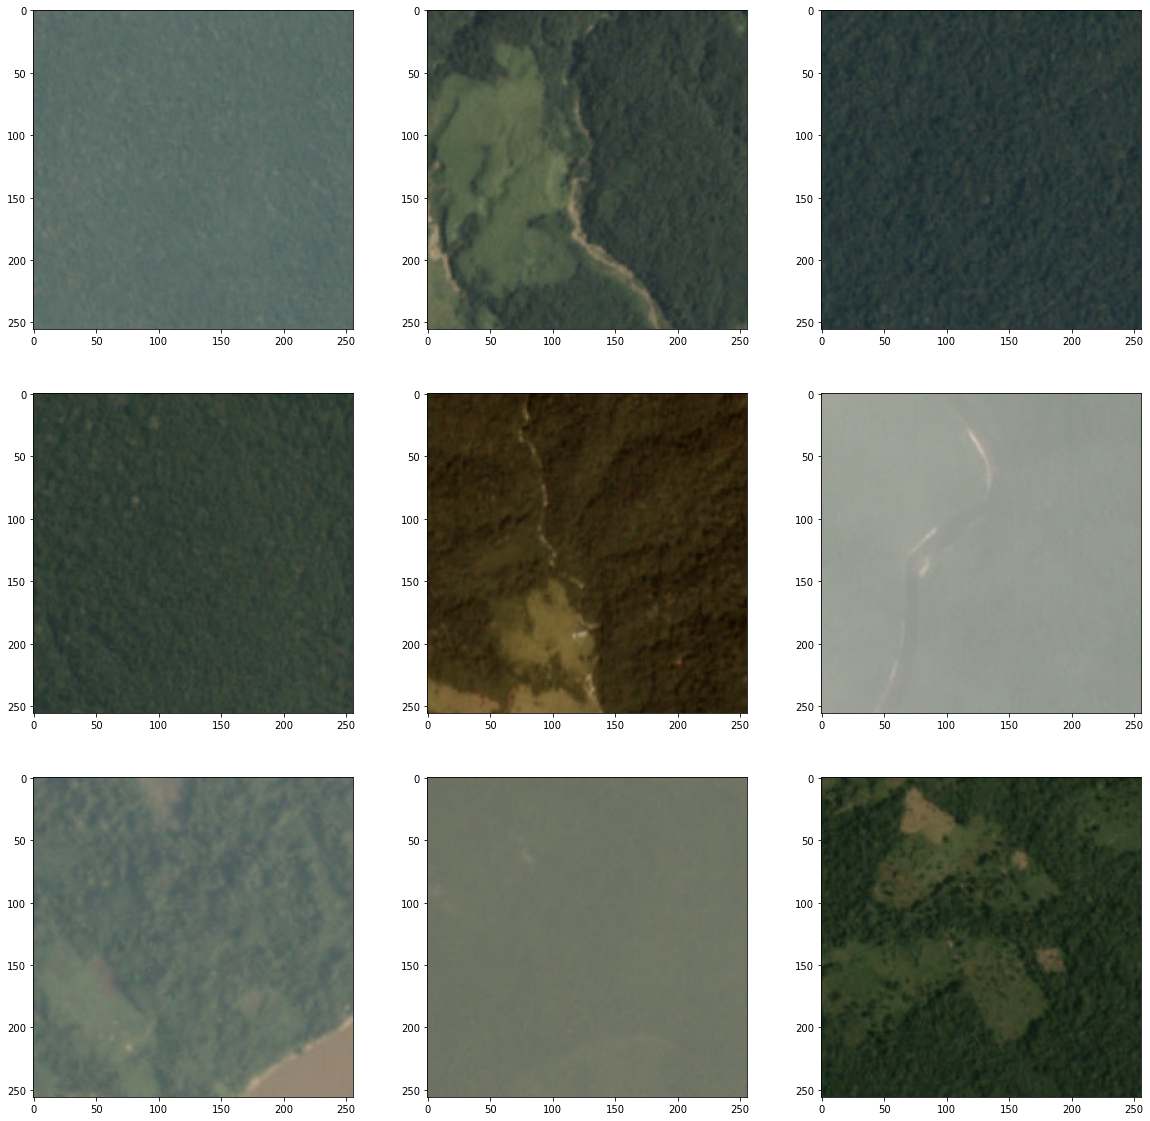

In [ ]:
plt.figure(figsize=(20,20))
# name location of dataset as folder
folder = '../input/planets-dataset/planet/planet/train-jpg/'
# plot first few images
for i in range(9):
	#subplot
	pyplot.subplot(330 + 1 + i)
	#filename
	filename = folder + 'train_' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

Read training and testing csv files

In [ ]:
df_train_data = pd.read_csv("../input/planets-dataset/planet/planet/train_classes.csv" )
df_test_data = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
df_train_data.head() # Checking out the first five rows


image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

In [ ]:
#change the tags column of the training dataset into a list and name flatten
flatten = lambda l: [item for sublist in l for item in sublist]


In [ ]:
labels = list (set(flatten([l.split (' ') for l in df_train_data ['tags'].values])))

In [ ]:
#label mapping
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

In [ ]:
print(label_map)

{'road': 0,
 'primary': 1,
 'agriculture': 2,
 'blow_down': 3,
 'water': 4,
 'partly_cloudy': 5,
 'habitation': 6,
 'bare_ground': 7,
 'haze': 8,
 'clear': 9,
 'selective_logging': 10,
 'cultivation': 11,
 'cloudy': 12,
 'conventional_mine': 13,
 'blooming': 14,
 'slash_burn': 15,
 'artisinal_mine': 16}

In [ ]:
gc.collect() 

40

Preprocessing data

In [ ]:
#train image dataset
x_train= []
y_train= []
for img, label in tqdm(df_train_data.values, miniters = 1000):
  target = np.zeros(17)
  
  #creating the 17-dimensional binary label vectors i.e One-hot encoding it
  for tag in label.split(' '):
    target[label_map[tag]]=1
  
  # Reshaping and assigning to arbitrary variables
  x_train.append(cv2.resize(cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(img)), (64,64)))
  y_train.append(target)

100%|██████████| 40479/40479 [02:32<00:00, 265.33it/s]


In [ ]:
len (x_train) # prints 40479


40479

In [ ]:
gc.collect()

60

In [ ]:
#Read test image dataset 
x_test = []
 
for img, label in tqdm(df_test_data[0:40669].values, miniters=1000):
    fil = cv2.resize(cv2.imread('../input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(img)), (64, 64))
    #merge test_additional jpg file
    x_test.append(fil)
 
 #Read test image dataset
for img, label in tqdm(df_test_data[40669:].values, miniters=1000):
    fil = cv2.resize(cv2.imread('../input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(img)), (64, 64))
    #merge test_additional jpg file
    x_test.append(fil)

100%|██████████| 20522/20522 [01:14<00:00, 275.21it/s]


In [ ]:
len (x_test) 

61191

In [ ]:
gc.collect()

60

In [ ]:
#convert lists to numpy arrays and normalize
x_train = np.array(x_train, np.float16)/255.
y_train = np.array(y_train, np.uint8)
x_test = np.array(x_test, np.float16)/255.

# Split training dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle = True, random_state = 1)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
# prints  (32383, 64, 64, 3) (32383, 17) (8096, 64, 64, 3) (8096, 17)

(32383, 64, 64, 3) (32383, 17) (8096, 64, 64, 3) (8096, 17)


In [ ]:
gc.collect()

40

Building model architecture with Custom CNN Architecture

In [ ]:
#Using custom CNN architecture for multilabel classification
input_size = 64
input_channels = 3
 
model = Sequential()

# Input layer
model.add(BatchNormalization(input_shape=(input_size, input_size, input_channels)))

# CCM_1
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#CCM_2
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
#CCM_3
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
#CCM_4
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


# Create a feature vector from the CCM_4 final layer
model.add(Flatten())

# Fully Connected (FC) Layer
model.add(Dense(512, activation='relu'))
model .add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer
model.add(Dense(17, activation='sigmoid'))

loading pre-trained VGG16 CNN Architecture


In [ ]:
import tensorflow.keras as keras
# Loading the pre-trained VGG16 architecture module
from tensorflow.keras.applications.vgg16 import VGG16



# Extract the pre - trained architecture
base_model = VGG16(input_shape =(input_size,input_size,3),include_top =False,weights ='imagenet')
base_model.summary()

# Get the output of the base_model formed above
x = base_model.output
# Flatten to obtain a feature vector
x = Flatten()(x)
# Connect the feature vector to to the fully connected (FC) layer
x = Dense (512 , activation ='relu')(x)
# Form the output label predictions
predictions = Dense (17 , activation ='sigmoid')(x)
model = Model(inputs= base_model.input,outputs = predictions)

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [ ]:
gc.collect()

20

## Model Training

In [ ]:
# Implementing ImageDataGenerator for data augmentation. 
datagen = ImageDataGenerator ( horizontal_flip =True, vertical_flip =True, zoom_range =0.2, rotation_range =90, fill_mode ='reflect')

In [ ]:
# Defining other parameters
epochs=20 
opt = keras.optimizers.Adam(learning_rate=0.0001) 

In [ ]:

# Compiling our model
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=[fbeta])


callbacks = [EarlyStopping(monitor='val_loss',
                           patience=2,
                           verbose=0)]

 

In [ ]:
gc.collect()

In [ ]:
# We fit our model now. The code below fits the model while generating extra images due to the Imagedatagenerator and fitting them on the fly!
model.fit_generator(datagen.flow(x_train, y_train, batch_size =24), steps_per_epoch =len(x_train)/32 ,
validation_data = datagen.flow ( x_val, y_val, batch_size =24), validation_steps =len(x_val)/32 , epochs =epochs, callbacks = callbacks, verbose =1)

In [ ]:
gc.collect()

In [ ]:
test_1 =[]
test_1.append (model.predict (x_test , batch_size = 128 , verbose =2) ) 
# We use the trained model for our test data prediction

In [ ]:
gc.collect()

In [ ]:
# After prediction, we compile the results in a pandas dataframe form
result = np.array (test_1[0])
for i in range (1,len(test_1) ):
 result += np. array (test_1)
result = pd.DataFrame (result,columns = labels )

In [ ]:
result

In [ ]:
preds = []
for i in tqdm(range(result.shape[0]), miniters=1000):
    a = result.loc[[i]]
    a = a.apply(lambda x: x > 0.2, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))
    

In [ ]:
# Saving to a csv file called "my_fourth_results"
df_test_data['tags'] = preds
df_test_data.to_csv('my_fourth_results.csv', index=False)
